In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [ ]:
num_samples = 1000
sample_range = range(600, 800)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:49, 16.44s/it]

Converged after 481 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.33s/it]

Converged after 478 outer iterations



Processing Samples:   0%|          | 1/200 [01:32<5:07:28, 92.71s/it]

Converged after 275 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.19s/it]

Converged after 442 outer iterations



Processing Samples:   1%|          | 2/200 [03:11<5:17:54, 96.34s/it]

Converged after 471 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.12s/it]

Converged after 378 outer iterations



Processing Samples:   2%|▏         | 3/200 [04:40<5:04:50, 92.85s/it]

Converged after 273 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.77s/it]

Converged after 416 outer iterations



Processing Samples:   2%|▏         | 4/200 [06:14<5:04:42, 93.28s/it]

Converged after 382 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.39s/it]

Converged after 424 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.55s/it]

Converged after 416 outer iterations



Processing Samples:   2%|▎         | 5/200 [07:48<5:04:16, 93.62s/it]

Converged after 386 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.27s/it]

Converged after 491 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.91s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.82s/it]

Converged after 477 outer iterations



Processing Samples:   3%|▎         | 6/200 [09:19<5:00:11, 92.84s/it]

Converged after 304 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.92s/it]

Converged after 442 outer iterations



Processing Samples:   4%|▎         | 7/200 [10:54<5:00:13, 93.33s/it]

Converged after 394 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:51, 17.13s/it]

Converged after 482 outer iterations



Processing Samples:   4%|▍         | 8/200 [12:32<5:04:01, 95.01s/it]

Converged after 413 outer iterations



Processing Samples:   4%|▍         | 9/200 [14:07<5:02:27, 95.01s/it]

Converged after 386 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.68s/it]

Converged after 406 outer iterations



Processing Samples:   5%|▌         | 10/200 [15:43<5:01:52, 95.33s/it]

Converged after 409 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.83s/it]

Converged after 342 outer iterations



Processing Samples:   6%|▌         | 11/200 [17:11<4:53:13, 93.08s/it]

Converged after 285 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.85s/it]

Converged after 449 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.98s/it]

Converged after 390 outer iterations



Processing Samples:   6%|▌         | 12/200 [18:41<4:48:12, 91.98s/it]

Converged after 325 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.72s/it]

Converged after 438 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.12s/it]

Converged after 403 outer iterations



Processing Samples:   6%|▋         | 13/200 [20:12<4:45:50, 91.72s/it]

Converged after 371 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:52, 17.58s/it]

Converged after 487 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.33s/it]

Converged after 337 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.12s/it]

Converged after 469 outer iterations



Processing Samples:   8%|▊         | 15/200 [23:23<4:47:56, 93.39s/it]

Converged after 313 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:48, 16.00s/it]

Converged after 457 outer iterations



Processing Samples:   8%|▊         | 16/200 [25:02<4:51:38, 95.10s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.04s/it]

Converged after 356 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.51s/it]

Converged after 443 outer iterations



Processing Samples:   9%|▉         | 18/200 [28:13<4:49:37, 95.48s/it]

Converged after 334 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:46, 15.59s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.76s/it]

Converged after 364 outer iterations



Processing Samples:  10%|▉         | 19/200 [29:44<4:43:50, 94.09s/it]

Converged after 417 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.91s/it]

Converged after 460 outer iterations



Processing Samples:  10%|█         | 20/200 [31:18<4:41:38, 93.88s/it]

Converged after 368 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.10s/it]

Converged after 424 outer iterations



Processing Samples:  10%|█         | 21/200 [32:53<4:41:05, 94.22s/it]

Converged after 327 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.87s/it]

Converged after 434 outer iterations



Processing Samples:  11%|█         | 22/200 [34:25<4:37:46, 93.63s/it]

Converged after 321 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:32, 16.40s/it]

Converged after 471 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.01s/it]

Converged after 277 outer iterations



Processing Samples:  12%|█▏        | 23/200 [35:52<4:30:34, 91.72s/it]

Converged after 323 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.03s/it]

Converged after 460 outer iterations



Processing Samples:  12%|█▏        | 24/200 [37:31<4:35:00, 93.75s/it]

Converged after 458 outer iterations



Processing Samples:  12%|█▎        | 25/200 [39:06<4:35:01, 94.29s/it]

Converged after 408 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.60s/it]

Converged after 439 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:13, 13.90s/it]

Converged after 304 outer iterations



Processing Samples:  13%|█▎        | 26/200 [40:37<4:30:11, 93.17s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:33<00:17, 17.94s/it]

Converged after 429 outer iterations



Processing Samples:  14%|█▎        | 27/200 [42:23<4:39:39, 96.99s/it]

Converged after 316 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:40<00:20, 20.37s/it]

Converged after 490 outer iterations



Processing Samples:  14%|█▍        | 28/200 [44:20<4:55:26, 103.06s/it]

Converged after 444 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.90s/it]

Converged after 451 outer iterations



Processing Samples:  14%|█▍        | 29/200 [45:56<4:48:09, 101.11s/it]

Converged after 394 outer iterations



Processing Samples:  15%|█▌        | 30/200 [47:30<4:40:28, 98.99s/it] 

Converged after 241 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.38s/it]

Converged after 417 outer iterations



Processing Samples:  16%|█▌        | 31/200 [49:01<4:31:50, 96.51s/it]

Converged after 339 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.44s/it]

Converged after 425 outer iterations



Processing Samples:  16%|█▌        | 32/200 [50:38<4:30:14, 96.51s/it]

Converged after 494 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.97s/it]

Converged after 465 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:15<01:18, 15.77s/it]

Converged after 489 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:51, 17.19s/it]

Converged after 488 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.76s/it]

Converged after 500 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.41s/it]

Converged after 376 outer iterations



Processing Samples:  17%|█▋        | 34/200 [53:49<4:25:03, 95.80s/it]

Converged after 356 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.74s/it]

Converged after 455 outer iterations



Processing Samples:  18%|█▊        | 35/200 [55:22<4:20:55, 94.88s/it]

Converged after 363 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.83s/it]

Converged after 469 outer iterations



Processing Samples:  18%|█▊        | 36/200 [56:53<4:16:20, 93.78s/it]

Converged after 315 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:32<01:03, 15.93s/it]

Converged after 473 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.36s/it]

Converged after 452 outer iterations



Processing Samples:  18%|█▊        | 37/200 [58:30<4:17:03, 94.62s/it]

Converged after 403 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.12s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.43s/it]

Converged after 458 outer iterations



Processing Samples:  19%|█▉        | 38/200 [1:00:03<4:14:44, 94.35s/it]

Converged after 294 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.46s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.26s/it]

Converged after 305 outer iterations



Processing Samples:  20%|█▉        | 39/200 [1:01:39<4:14:30, 94.85s/it]

Converged after 320 outer iterations



Processing Samples:  20%|██        | 40/200 [1:03:29<4:24:48, 99.30s/it]

Converged after 413 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.95s/it]

Converged after 476 outer iterations



Processing Samples:  20%|██        | 41/200 [1:05:03<4:19:06, 97.77s/it]

Converged after 401 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.77s/it]

Converged after 394 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.52s/it]

Converged after 420 outer iterations



Processing Samples:  21%|██        | 42/200 [1:06:30<4:09:06, 94.60s/it]

Converged after 312 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.52s/it]

Converged after 438 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.95s/it]

Converged after 419 outer iterations



Processing Samples:  22%|██▏       | 43/200 [1:07:57<4:01:31, 92.30s/it]

Converged after 269 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.23s/it]

Converged after 420 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.44s/it]

Converged after 368 outer iterations



Processing Samples:  22%|██▏       | 44/200 [1:09:24<3:55:51, 90.72s/it]

Converged after 329 outer iterations



Processing Samples:  22%|██▎       | 45/200 [1:11:02<3:59:57, 92.88s/it]

Converged after 451 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.28s/it]

Converged after 440 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.25s/it]

Converged after 471 outer iterations



Processing Samples:  23%|██▎       | 46/200 [1:12:36<3:58:47, 93.04s/it]

Converged after 487 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.25s/it]

Converged after 466 outer iterations



Processing Samples:  24%|██▍       | 48/200 [1:15:51<4:01:10, 95.20s/it]

Converged after 410 outer iterations



Processing Samples:  24%|██▍       | 49/200 [1:17:22<3:56:25, 93.95s/it]

Converged after 331 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.77s/it]

Converged after 443 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.26s/it]

Converged after 327 outer iterations



Processing Samples:  25%|██▌       | 50/200 [1:18:51<3:51:13, 92.49s/it]

Converged after 455 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.88s/it]

Converged after 476 outer iterations



Processing Samples:  26%|██▌       | 51/200 [1:20:26<3:51:21, 93.16s/it]

Converged after 436 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:45, 15.23s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.98s/it]

Converged after 323 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.13s/it]

Converged after 433 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.12s/it]

Converged after 397 outer iterations



Processing Samples:  26%|██▋       | 53/200 [1:23:22<3:42:02, 90.63s/it]

Converged after 300 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:15, 15.86s/it]

Converged after 456 outer iterations



Processing Samples:  27%|██▋       | 54/200 [1:24:57<3:43:18, 91.77s/it]

Converged after 362 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.39s/it]

Converged after 483 outer iterations



Processing Samples:  28%|██▊       | 55/200 [1:26:29<3:42:07, 91.91s/it]

Converged after 377 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:30, 15.42s/it]

Converged after 410 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.54s/it]

Converged after 388 outer iterations



Processing Samples:  28%|██▊       | 56/200 [1:27:54<3:35:38, 89.85s/it]

Converged after 300 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.32s/it]

Converged after 457 outer iterations



Processing Samples:  28%|██▊       | 57/200 [1:29:31<3:39:22, 92.04s/it]

Converged after 491 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.21s/it]

Converged after 353 outer iterations



Processing Samples:  29%|██▉       | 58/200 [1:31:02<3:37:05, 91.73s/it]

Converged after 452 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.46s/it]

Converged after 435 outer iterations



Processing Samples:  30%|██▉       | 59/200 [1:32:34<3:35:40, 91.78s/it]

Converged after 332 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.04s/it]

Converged after 405 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.25s/it]

Converged after 492 outer iterations



Processing Samples:  30%|███       | 60/200 [1:34:03<3:31:48, 90.78s/it]

Converged after 309 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.82s/it]

Converged after 482 outer iterations



Processing Samples:  30%|███       | 61/200 [1:35:37<3:32:25, 91.70s/it]

Converged after 403 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.01s/it]

Converged after 484 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.74s/it]

Converged after 460 outer iterations



Processing Samples:  31%|███       | 62/200 [1:37:08<3:30:42, 91.61s/it]

Converged after 313 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:38:45<3:32:44, 93.17s/it]

Converged after 445 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 15.00s/it]

Converged after 397 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:40:13<3:28:09, 91.84s/it]

Converged after 315 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:47, 15.98s/it]

Converged after 468 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.71s/it]

Converged after 479 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.72s/it]

Converged after 382 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:41:42<3:24:33, 90.92s/it]

Converged after 351 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:43:21<3:28:18, 93.27s/it]

Converged after 492 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.95s/it]

Converged after 489 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.06s/it]

Converged after 381 outer iterations



Processing Samples:  34%|███▎      | 67/200 [1:44:51<3:24:29, 92.25s/it]

Converged after 351 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.13s/it]

Converged after 419 outer iterations



Processing Samples:  34%|███▍      | 69/200 [1:47:59<3:22:45, 92.86s/it]

Converged after 322 outer iterations



Processing Samples:  35%|███▌      | 70/200 [1:49:36<3:23:40, 94.00s/it]

Converged after 419 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:45, 15.32s/it]

Converged after 447 outer iterations



Processing Samples:  36%|███▌      | 71/200 [1:51:10<3:22:12, 94.05s/it]

Converged after 469 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:50<00:49, 16.39s/it]

Converged after 462 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.91s/it]

Converged after 372 outer iterations



Processing Samples:  36%|███▌      | 72/200 [1:52:41<3:18:26, 93.02s/it]

Converged after 334 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.36s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.35s/it]

Converged after 474 outer iterations



Processing Samples:  36%|███▋      | 73/200 [1:54:10<3:14:15, 91.78s/it]

Converged after 321 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.72s/it]

Converged after 386 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.83s/it]

Converged after 487 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.11s/it]

Converged after 417 outer iterations



Processing Samples:  38%|███▊      | 75/200 [1:57:16<3:11:44, 92.03s/it]

Converged after 339 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.16s/it]

Converged after 421 outer iterations



Processing Samples:  38%|███▊      | 76/200 [1:58:44<3:08:06, 91.02s/it]

Converged after 313 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.75s/it]

Converged after 399 outer iterations



Processing Samples:  38%|███▊      | 77/200 [2:00:16<3:07:21, 91.40s/it]

Converged after 391 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:48<00:48, 16.08s/it]

Converged after 490 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.23s/it]

Converged after 426 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.19s/it]

Converged after 470 outer iterations



Processing Samples:  39%|███▉      | 78/200 [2:01:41<3:01:34, 89.30s/it]

Converged after 252 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.17s/it]

Converged after 487 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.93s/it]

Converged after 369 outer iterations



Processing Samples:  40%|███▉      | 79/200 [2:03:13<3:01:59, 90.25s/it]

Converged after 407 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.61s/it]

Converged after 473 outer iterations



Processing Samples:  40%|████      | 80/200 [2:04:45<3:01:34, 90.79s/it]

Converged after 405 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:29, 14.92s/it]

Converged after 365 outer iterations



Processing Samples:  40%|████      | 81/200 [2:06:21<3:03:00, 92.27s/it]

Converged after 490 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.86s/it]

Converged after 488 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.96s/it]

Converged after 401 outer iterations



Processing Samples:  41%|████      | 82/200 [2:07:51<3:00:20, 91.70s/it]

Converged after 388 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.88s/it]

Converged after 449 outer iterations



Processing Samples:  42%|████▏     | 83/200 [2:09:29<3:02:14, 93.46s/it]

Converged after 473 outer iterations



Processing Samples:  42%|████▏     | 84/200 [2:11:02<3:00:25, 93.32s/it]

Converged after 386 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.08s/it]

Converged after 351 outer iterations



Processing Samples:  42%|████▎     | 85/200 [2:12:34<2:58:21, 93.06s/it]

Converged after 352 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.87s/it]

Converged after 485 outer iterations



Processing Samples:  43%|████▎     | 86/200 [2:14:05<2:55:37, 92.43s/it]

Converged after 286 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.74s/it]

Converged after 385 outer iterations



Processing Samples:  44%|████▎     | 87/200 [2:15:44<2:57:32, 94.27s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.76s/it]

Converged after 403 outer iterations



Processing Samples:  44%|████▍     | 88/200 [2:17:31<3:03:00, 98.04s/it]

Converged after 411 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.08s/it]

Converged after 447 outer iterations



Processing Samples:  44%|████▍     | 89/200 [2:19:23<3:09:11, 102.26s/it]

Converged after 441 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.98s/it]

Converged after 408 outer iterations



Processing Samples:  45%|████▌     | 90/200 [2:21:10<3:09:56, 103.61s/it]

Converged after 415 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.29s/it]

Converged after 481 outer iterations



Processing Samples:  46%|████▌     | 91/200 [2:22:58<3:11:02, 105.16s/it]

Converged after 475 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.15s/it]

Converged after 436 outer iterations



Processing Samples:  46%|████▌     | 92/200 [2:24:45<3:10:01, 105.57s/it]

Converged after 348 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:34, 17.34s/it]

Converged after 445 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.59s/it]

Converged after 468 outer iterations



Processing Samples:  46%|████▋     | 93/200 [2:26:26<3:05:45, 104.17s/it]

Converged after 367 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:51<00:51, 17.04s/it]

Converged after 483 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.22s/it]

Converged after 373 outer iterations



Processing Samples:  47%|████▋     | 94/200 [2:27:55<2:56:04, 99.67s/it] 

Converged after 352 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.01s/it]

Converged after 455 outer iterations



Processing Samples:  48%|████▊     | 95/200 [2:29:31<2:52:17, 98.45s/it]

Converged after 453 outer iterations



Processing Samples:  48%|████▊     | 96/200 [2:31:17<2:54:50, 100.87s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.62s/it]

Converged after 464 outer iterations



Processing Samples:  48%|████▊     | 97/200 [2:33:00<2:54:14, 101.50s/it]

Converged after 333 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:49<00:48, 16.13s/it]

Converged after 446 outer iterations



Processing Samples:  49%|████▉     | 98/200 [2:34:38<2:50:27, 100.27s/it]

Converged after 483 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.75s/it]

Converged after 480 outer iterations



Processing Samples:  50%|████▉     | 99/200 [2:36:14<2:46:40, 99.02s/it] 

Converged after 387 outer iterations



Processing Samples:  50%|█████     | 100/200 [2:37:48<2:42:51, 97.72s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.35s/it]

Converged after 406 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.13s/it]

Converged after 430 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.71s/it]

Converged after 367 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.98s/it]

Converged after 484 outer iterations



Processing Samples:  52%|█████▏    | 103/200 [2:42:30<2:33:13, 94.77s/it]

Converged after 394 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.31s/it]

Converged after 424 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [2:44:00<2:29:04, 93.17s/it]

Converged after 322 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.44s/it]

Converged after 483 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.08s/it]

Converged after 480 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [2:47:43<2:40:17, 102.31s/it]

Converged after 430 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.05s/it]

Converged after 432 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [2:51:20<2:41:12, 105.13s/it]

Converged after 286 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:58<00:58, 19.37s/it]

Converged after 499 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:35, 17.73s/it]

Converged after 411 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.07s/it]

Converged after 500 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [2:55:02<2:42:12, 108.14s/it]

Converged after 437 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.71s/it]

Converged after 436 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [2:56:49<2:40:06, 107.94s/it]

Converged after 453 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:16, 16.87s/it]

Converged after 379 outer iterations



Processing Samples:  56%|█████▌    | 112/200 [2:58:31<2:35:41, 106.15s/it]

Converged after 301 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.72s/it]

Converged after 497 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.12s/it]

Converged after 425 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [3:00:15<2:32:50, 105.41s/it]

Converged after 305 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.28s/it]

Converged after 471 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [3:02:04<2:32:51, 106.65s/it]

Converged after 407 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:31, 15.52s/it]

Converged after 433 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.82s/it]

Converged after 436 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.39s/it]

Converged after 448 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [3:05:12<2:19:50, 99.89s/it] 

Converged after 331 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.28s/it]

Converged after 314 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [3:06:41<2:13:33, 96.54s/it]

Converged after 404 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.23s/it]

Converged after 454 outer iterations



Processing Samples:  59%|█████▉    | 118/200 [3:08:11<2:09:23, 94.68s/it]

Converged after 293 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [3:09:49<2:09:20, 95.80s/it]

Converged after 367 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.10s/it]

Converged after 398 outer iterations



Processing Samples:  60%|██████    | 120/200 [3:11:17<2:04:29, 93.37s/it]

Converged after 255 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.81s/it]

Converged after 495 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.12s/it]

Converged after 423 outer iterations



Processing Samples:  60%|██████    | 121/200 [3:12:49<2:02:34, 93.09s/it]

Converged after 473 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.67s/it]

Converged after 430 outer iterations



Processing Samples:  61%|██████    | 122/200 [3:14:25<2:01:50, 93.72s/it]

Converged after 418 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.67s/it]

Converged after 462 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [3:15:59<2:00:34, 93.95s/it]

Converged after 446 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:29, 14.94s/it]

Converged after 364 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.62s/it]

Converged after 431 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [3:17:23<1:55:10, 90.93s/it]

Converged after 265 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.68s/it]

Converged after 420 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.58s/it]

Converged after 480 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [3:18:55<1:54:09, 91.32s/it]

Converged after 351 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.08s/it]

Converged after 397 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.80s/it]

Converged after 439 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [3:20:21<1:50:25, 89.53s/it]

Converged after 256 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:46<00:45, 15.11s/it]

Converged after 426 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.19s/it]

Converged after 379 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [3:21:47<1:47:44, 88.56s/it]

Converged after 348 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:08<00:34, 17.28s/it]

Converged after 489 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:25<00:17, 17.33s/it]

Converged after 409 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [3:23:32<1:52:04, 93.40s/it]

Converged after 457 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.60s/it]

Converged after 477 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.09s/it]

Converged after 472 outer iterations



Processing Samples:  65%|██████▌   | 130/200 [3:27:15<2:00:15, 103.07s/it]

Converged after 448 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.32s/it]

Converged after 471 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.06s/it]

Converged after 367 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [3:28:55<1:57:16, 101.98s/it]

Converged after 220 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:53<00:52, 17.66s/it]

Converged after 475 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [3:30:42<1:57:19, 103.52s/it]

Converged after 379 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.37s/it]

Converged after 410 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [3:32:24<1:55:09, 103.12s/it]

Converged after 283 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.08s/it]

Converged after 424 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.38s/it]

Converged after 438 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [3:34:06<1:52:52, 102.61s/it]

Converged after 278 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.87s/it]

Converged after 387 outer iterations



Processing Samples:  68%|██████▊   | 135/200 [3:35:53<1:52:35, 103.93s/it]

Converged after 438 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:56<00:57, 19.23s/it]

Converged after 484 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.04s/it]

Converged after 458 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:26<00:15, 15.95s/it]

Converged after 309 outer iterations



Processing Samples:  68%|██████▊   | 137/200 [3:39:23<1:49:23, 104.18s/it]

Converged after 371 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:16<00:37, 18.91s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.44s/it]

Converged after 390 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [3:41:08<1:48:02, 104.55s/it]

Converged after 389 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [3:42:59<1:48:06, 106.34s/it]

Converged after 358 outer iterations



Processing Samples:  70%|███████   | 140/200 [3:44:45<1:46:15, 106.26s/it]

Converged after 305 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.22s/it]

Converged after 350 outer iterations



Processing Samples:  70%|███████   | 141/200 [3:46:26<1:43:00, 104.76s/it]

Converged after 298 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:52<00:52, 17.62s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.48s/it]

Converged after 438 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.29s/it]

Converged after 304 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [3:51:33<1:34:30, 101.25s/it]

Converged after 270 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.19s/it]

Converged after 427 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [3:53:04<1:29:57, 98.14s/it] 

Converged after 378 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.80s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.06s/it]

Converged after 457 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [3:54:35<1:26:11, 95.77s/it]

Converged after 340 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:14, 14.88s/it]

Converged after 356 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [3:56:08<1:24:00, 95.10s/it]

Converged after 435 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [3:57:47<1:23:30, 96.35s/it]

Converged after 470 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.15s/it]

Converged after 381 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.49s/it]

Converged after 395 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [3:59:16<1:19:47, 93.87s/it]

Converged after 363 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.24s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.86s/it]

Converged after 320 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [4:00:41<1:16:06, 91.34s/it]

Converged after 341 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.95s/it]

Converged after 402 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.50s/it]

Converged after 390 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.62s/it]

Converged after 387 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.23s/it]

Converged after 359 outer iterations



Processing Samples:  76%|███████▋  | 153/200 [4:05:19<1:11:54, 91.80s/it]

Converged after 293 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.07s/it]

Converged after 462 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.61s/it]

Converged after 385 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [4:10:48<1:15:33, 103.04s/it]

Converged after 379 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.34s/it]

Converged after 480 outer iterations



Processing Samples:  78%|███████▊  | 157/200 [4:12:41<1:15:51, 105.84s/it]

Converged after 425 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.37s/it]

Converged after 454 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.72s/it]

Converged after 450 outer iterations



Processing Samples:  79%|███████▉  | 158/200 [4:14:25<1:13:50, 105.49s/it]

Converged after 373 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:55<00:56, 18.96s/it]

Converged after 473 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.71s/it]

Converged after 429 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [4:16:09<1:11:41, 104.91s/it]

Converged after 372 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.01s/it]

Converged after 423 outer iterations



Processing Samples:  80%|████████  | 160/200 [4:17:51<1:09:23, 104.09s/it]

Converged after 388 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.82s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.40s/it]

Converged after 450 outer iterations



Processing Samples:  80%|████████  | 161/200 [4:19:21<1:04:48, 99.70s/it] 

Converged after 320 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:33, 16.86s/it]

Converged after 496 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:14, 14.60s/it]

Converged after 378 outer iterations



Processing Samples:  81%|████████  | 162/200 [4:20:49<1:01:01, 96.34s/it]

Converged after 347 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.77s/it]

Converged after 434 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.78s/it]

Converged after 492 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [4:22:24<59:07, 95.88s/it]  

Converged after 429 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [4:23:58<57:07, 95.20s/it]

Converged after 422 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.26s/it]

Converged after 492 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.63s/it]

Converged after 451 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.62s/it]

Converged after 402 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [4:27:09<54:03, 95.40s/it]

Converged after 428 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.60s/it]

Converged after 373 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [4:28:40<51:42, 94.03s/it]

Converged after 449 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.69s/it]

Converged after 315 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.25s/it]

Converged after 490 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.72s/it]

Converged after 346 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [4:31:46<48:25, 93.72s/it]

Converged after 494 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.89s/it]

Converged after 398 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.95s/it]

Converged after 466 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.32s/it]

Converged after 404 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [4:34:54<45:17, 93.71s/it]

Converged after 432 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.67s/it]

Converged after 485 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.41s/it]

Converged after 364 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.74s/it]

Converged after 475 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [4:36:20<42:37, 91.35s/it]

Converged after 303 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.20s/it]

Converged after 444 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [4:37:49<40:48, 90.69s/it]

Converged after 302 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.66s/it]

Converged after 406 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:13, 13.15s/it]

Converged after 339 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [4:39:17<38:56, 89.85s/it]

Converged after 448 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [4:40:52<38:09, 91.58s/it]

Converged after 387 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.50s/it]

Converged after 467 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [4:42:29<37:16, 93.19s/it]

Converged after 446 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.97s/it]

Converged after 477 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:16, 16.03s/it]

Converged after 494 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [4:44:00<35:25, 92.41s/it]

Converged after 282 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [4:45:35<34:11, 93.25s/it]

Converged after 325 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.44s/it]

Converged after 451 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.55s/it]

Converged after 380 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.87s/it]

Converged after 496 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.42s/it]

Converged after 366 outer iterations



Processing Samples:  90%|█████████ | 180/200 [4:48:37<30:38, 91.93s/it]

Converged after 408 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.51s/it]

Converged after 418 outer iterations



Processing Samples:  90%|█████████ | 181/200 [4:50:10<29:14, 92.35s/it]

Converged after 356 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:31, 15.95s/it]

Converged after 495 outer iterations



Processing Samples:  91%|█████████ | 182/200 [4:51:42<27:42, 92.36s/it]

Converged after 351 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.18s/it]

Converged after 347 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [4:53:09<25:42, 90.72s/it]

Converged after 301 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.35s/it]

Converged after 398 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [4:54:41<24:19, 91.20s/it]

Converged after 352 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:46, 15.60s/it]

Converged after 477 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [4:56:11<22:42, 90.84s/it]

Converged after 311 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [4:57:43<21:12, 90.91s/it]

Converged after 327 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:06<00:32, 16.30s/it]

Converged after 476 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [4:59:17<19:56, 92.05s/it]

Converged after 355 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.29s/it]

Converged after 417 outer iterations



Processing Samples:  94%|█████████▍| 188/200 [5:00:46<18:11, 90.97s/it]

Converged after 256 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:04<00:32, 16.06s/it]

Converged after 481 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:23<00:17, 17.15s/it]

Converged after 476 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:21<00:16, 16.51s/it]

Converged after 486 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [5:05:37<14:10, 94.49s/it]

Converged after 349 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [5:07:14<12:40, 95.05s/it]

Converged after 395 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.55s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.42s/it]

Converged after 346 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [5:08:43<10:52, 93.19s/it]

Converged after 391 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:14, 14.74s/it]

Converged after 362 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [5:10:12<09:11, 91.90s/it]

Converged after 356 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [5:11:51<07:50, 94.06s/it]

Converged after 492 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:05<00:31, 15.71s/it]

Converged after 406 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [5:13:25<06:16, 94.20s/it]

Converged after 378 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [5:14:59<04:42, 94.02s/it]

Converged after 402 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:30, 15.28s/it]

Converged after 366 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.11s/it]

Converged after 434 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [5:16:31<03:07, 93.59s/it]

Converged after 416 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:02<00:30, 15.50s/it]

Converged after 452 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.09s/it]

Converged after 439 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [5:18:04<01:33, 93.18s/it]

Converged after 450 outer iterations



Processing Samples: 100%|██████████| 200/200 [5:19:41<00:00, 95.91s/it]

Converged after 350 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [13.825 18.04  19.455 19.9   19.98  20.   ]
Avg SRR : [0.07608687 0.12312242 0.16231733 0.19300884 0.19957143 0.2       ]
Avg FR  : [6.40526316e-01 4.31052632e-01 1.94210526e-01 3.05263158e-02
 2.63157895e-04 0.00000000e+00]
Avg PR  : [0.10792627 0.13891402 0.16921029 0.19465649 0.19995238 0.2       ]
Avg RE  : [0.13825 0.1804  0.19455 0.199   0.1998  0.2    ]
Avg F1  : [0.12085784 0.15664714 0.18070471 0.19672271 0.19987305 0.2       ]
Avg NMSE: [0.10830978 0.06241406 0.03017484 0.01053561 0.00369195 0.00153184]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-all-pilot-length-30-set-4.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


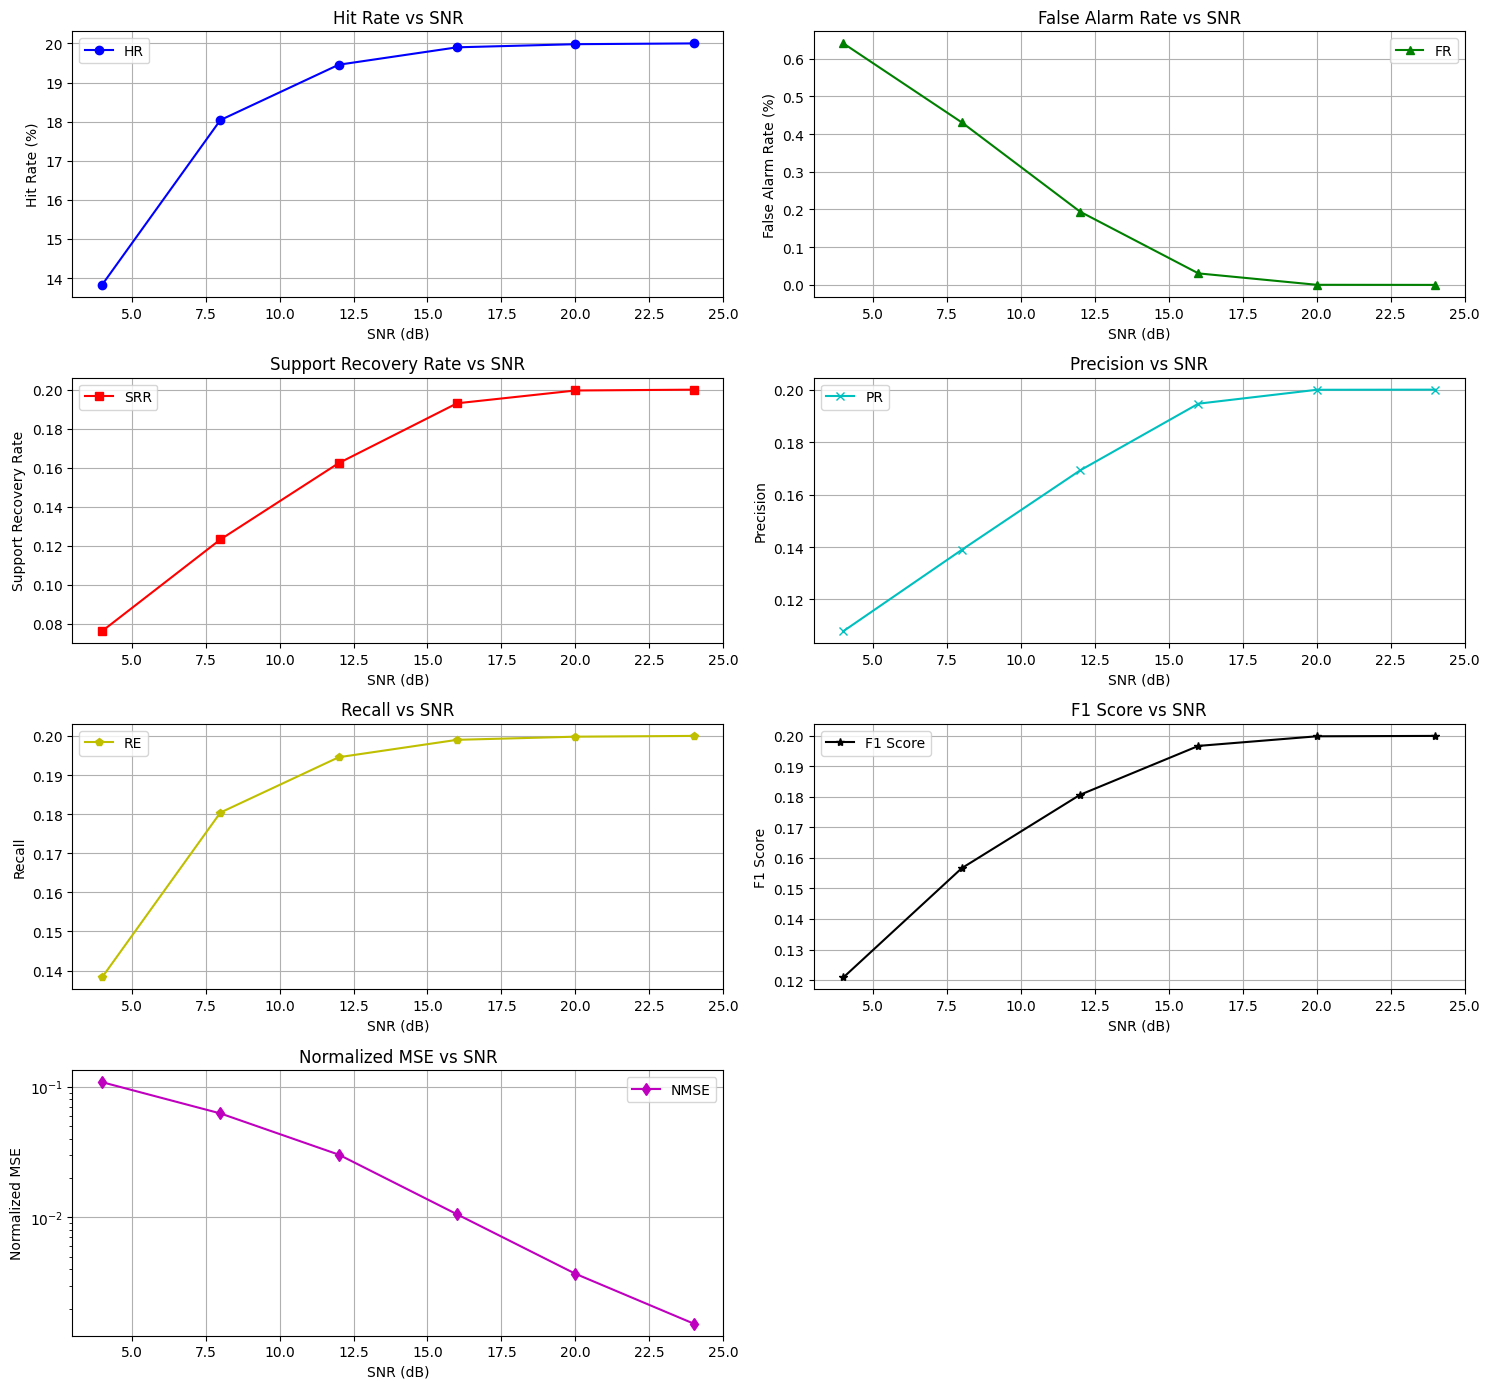

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

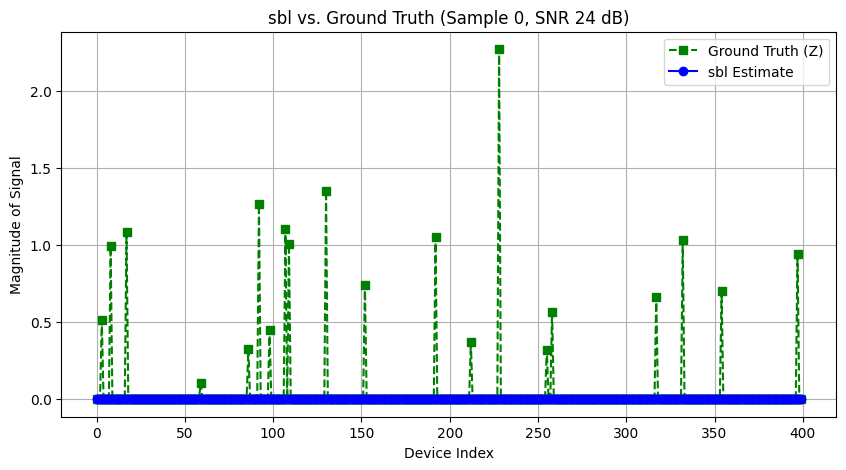

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


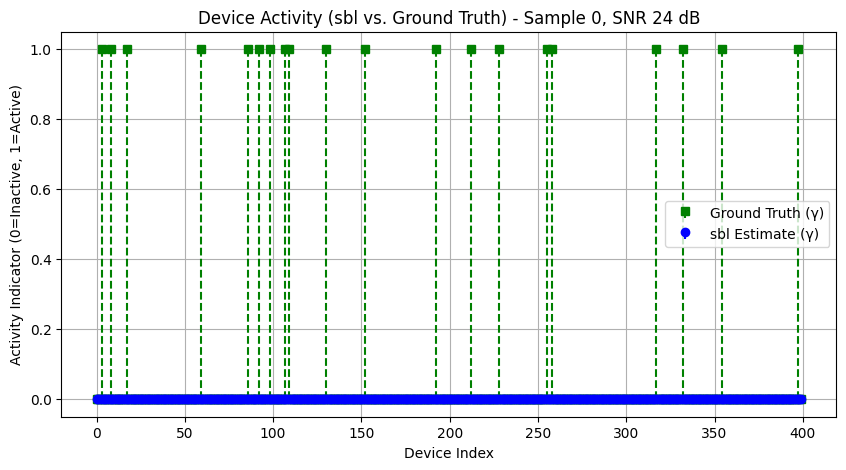

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)